# Decision Tree Classification  
## Predicting Pass / Fail Based on Weekly Study Hours

### Scenario
You have an existing dataset from a previous cohort (40 students):  
- **study_hours** (hours studied per week)  
- **passed** (1 = pass, 0 = fail)

You will train a **Decision Tree classifier** on this cohort and then use it to predict **pass/fail** for a **new class** based on their current study hours.

### Learning objectives
- Understand how a **decision tree** performs binary classification.
- See how **feature thresholds** translate into decisions.
- Practice applying a trained model to **new, unseen data**.
- Model good Python practices: reproducibility, clear structure, and interpretation.


In [2]:
# Core numerical and data handling libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Machine learning tools
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Reproducibility: fix randomness so everyone sees the same results
np.random.seed(42)


## 1) Build a student-friendly dataset (40 students)

We simulate a simple but realistic dataset:
- `study_hours`: hours studied per week  
- `passed`: 1 = pass, 0 = fail  

We also introduce a little label noise to reflect the fact that real outcomes are not perfectly explained by one feature.


In [ ]:
# Generate study hours for 40 students (1 to 24 hours/week)
study_hours = np.random.randint(1, 25, size=40)

# Base rule: students studying 10+ hours/week tend to pass
passed = (study_hours >= 10).astype(int)

# Add mild noise (real life is messy)
# Some students pass despite low hours, and some fail despite higher hours
# Randomly pick a few students to receive label flips
# Flip pass/fail labels for those selected students
noise_indices = np.random.choice(range(40), size=4, replace=False)
# Flip labels for those indices: 1->0 and 0->1
passed[noise_indices] = 1 - passed[noise_indices]

students_df = pd.DataFrame({
    "study_hours": study_hours,
    "passed": passed
})

students_df.head(10)


,study_hours,passed
0,7,1
1,20,1
2,15,1
3,11,1
4,8,0
5,21,1
6,7,0
7,19,1
8,23,1
9,11,1


## 2) Quick visualization (EDA)

A single feature classification problem is intentionally simple for teaching:
students can visually see where the model might learn a threshold.


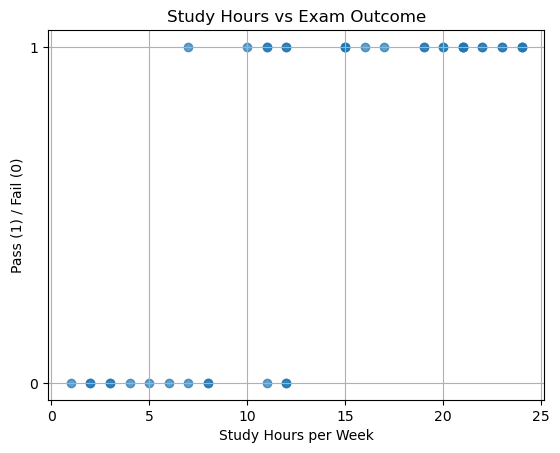

In [13]:
plt.scatter(
    students_df["study_hours"],
    students_df["passed"],
    alpha=0.7
)

plt.xlabel("Study Hours per Week")
plt.ylabel("Pass (1) / Fail (0)")
plt.title("Study Hours vs Exam Outcome")
plt.yticks([0, 1])
plt.grid(True)
plt.show()


### Interpretation
- There is a visible “threshold-ish” region around **10 hours/week**.
- The few points that violate the pattern represent noise or unobserved factors (attendance, prior knowledge, etc.).
- This is a realistic setup: ML models learn patterns, not certainty.


## 3) Train–test split

We split data into training and test sets to estimate how well the model generalizes.  
We use **stratification** to preserve the pass/fail ratio in both splits.


In [14]:
X = students_df[["study_hours"]]
y = students_df["passed"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((30, 1), (10, 1))

## 4) Train a Decision Tree classifier

We intentionally constrain tree complexity (`max_depth=2`) to:
- reduce overfitting
- keep the model interpretable


In [20]:
tree_model = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=2,
    random_state=42
)

tree_model.fit(X_train, y_train)


,criterion,'entropy'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## 5) Evaluate the model on the test set

We compute:
- accuracy
- confusion matrix
- classification report (precision, recall, f1)


In [21]:
y_pred = tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.80

Confusion Matrix:
[[4 0]
 [2 4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.67      0.80         6

    accuracy                           0.80        10
   macro avg       0.83      0.83      0.80        10
weighted avg       0.87      0.80      0.80        10



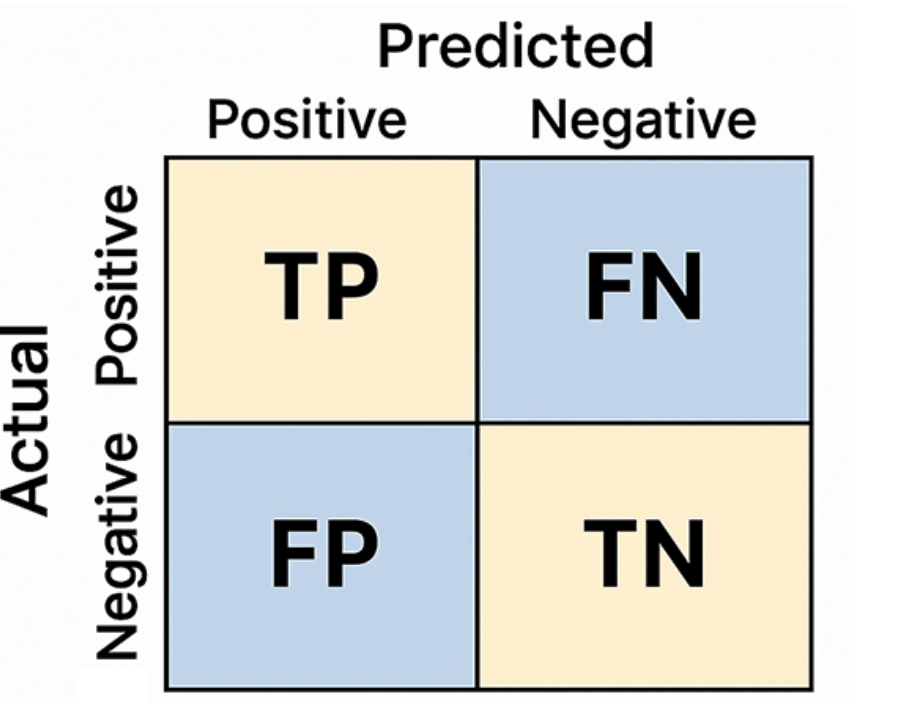


### Interpretation
- With a small dataset and label noise, perfect accuracy is not expected.
- Misclassifications are informative: they suggest missing features (motivation, tutoring, attendance).
- The goal here is interpretability and process, not squeezing out performance.


## 6) Visualize the learned tree

This is the key teaching moment: the tree shows decision thresholds explicitly.


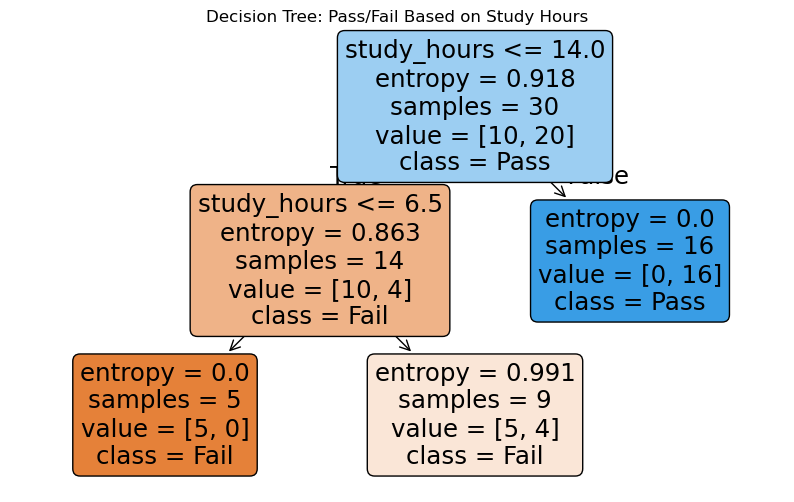

In [22]:
plt.figure(figsize=(10, 6))

plot_tree(
    tree_model,
    feature_names=["study_hours"],
    class_names=["Fail", "Pass"],
    filled=True,
    rounded=True
)

plt.title("Decision Tree: Pass/Fail Based on Study Hours")
plt.show()


## 7) Apply the model to a new class

Now we simulate a **new cohort** with only current study hours.  
We predict who is likely to pass/fail based on what the model learned from the prior cohort.


In [23]:
new_class = pd.DataFrame({
    "study_hours": [4, 7, 9, 11, 14, 18]
})

new_class


,study_hours
0,4
1,7
2,9
3,11
4,14
5,18


In [10]:
new_class["predicted_pass"] = tree_model.predict(new_class)

new_class


,study_hours,predicted_pass
0,4,0
1,7,0
2,9,0
3,11,1
4,14,1
5,18,1


### Interpretation
- These are model-based predictions from historical patterns, not guarantees.
- A student around the boundary (for example 9–11 hours) is where uncertainty is naturally higher.


## 8) Optional: predict probabilities (more honest than hard labels)

Probabilities help students understand that classification decisions often include uncertainty.  
A label like “Pass” might correspond to 0.55 probability, which is not a confident prediction.


In [12]:
new_class["pass_probability"] = tree_model.predict_proba(new_class[["study_hours"]])[:, 1]

new_class


,study_hours,predicted_pass,pass_probability
0,4,0,0.00
1,7,0,0.25
2,9,0,0.25
3,11,1,0.60
4,14,1,0.60
5,18,1,1.00


## Final summary
- Decision trees learn **if-then rules** from data.
- Constraining depth improves interpretability and reduces overfitting.
- A trained model can be applied to **new students** to support decision-making.
- Probabilities provide a richer view than binary predictions.
